# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [22]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import wget
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import median

## Support functions and variables

In [23]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [27]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [120]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########

    matrix =  np.zeros((num_users, num_items))
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [30]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
          # select the row for user
          # what's the shape of userVector
            userVector = train_matrix[user, :]
            
            # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
                
          # report progress every 100 users
          if (user % 100 == 0 and item == 1):
              print ("calculated %d users" % (user,))
        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
         # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
              itemPopularity[item] = 0
            else:
              itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]
            
        # report progress every 100 users
          if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [33]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [35]:
x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.        , 0.37777778, ..., 0.        , 0.        ,
        0.        ]])

In [36]:
np.all(x<=1)

True

In [37]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [38]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:40, 998.32it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [40]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [41]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [42]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:38, 1014.64it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1/(pairwise_distances(matrix, metric = 'euclidean') + 1 )
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = 1/(pairwise_distances(matrix, metric = 'manhattan') + 1 )
    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, train_matrix)
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)  + 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = train_matrix.T
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(ii_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, train_matrix)
            
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)

            self.__model = predictionMatrix.T
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [44]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [45]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [46]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

Cosine is a better metric since it considers the angel differences between vectors instead of distance between two vectors. It handles and normalizes the vectors with different lengths. (if people have different standards, more positive people will have higher ratings than negative people. But if the ratings are porpotionally, it means they actually rated the same. Using euclidean will exaggerate the distance which is incorrect ) 

### (b)

Manhattan may be appropriate if different dimensions are not comparable since it considers the absolute distance(d = |xi-xj|+|yi-yj|) and it works well for high dimensional vectors than euclidean. In the movie lens data, we have high dimensional vectors here.

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [49]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [50]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [51]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:45, 948.36it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [0]:
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [54]:
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [55]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:41, 987.25it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# # 1. gather your algorithms in previous steps.
# algorithm_instances = [popularity_recsys, 
#                        average_user_rating_recsys, 
#                        user_cosine_recsys]

In [0]:
# # 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# # RMSE, P@K, R@K
# # Precision at K in this example
# cv_patk = CrossValidation('P@K')

In [0]:
# # 3. Run CV by giving:
# #    1> algorithms just gathered
# #    2> number of users in the full dataset
# #    3> number of items in the full dataset
# #    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# # Results include independent results from 5 folds, their mean, and confidence interval.
# cv_patk.run(algorithm_instances, num_users, num_items,k=5)

In [139]:
algorithm_instances = [user_cosine_recsys, item_cosine_recsys]
cv_RMSE = CrossValidation('RMSE')
Q3_comp = cv_RMSE.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:09, 2110.75it/s]
20000it [00:09, 2122.18it/s]
20000it [00:09, 2037.12it/s]
20000it [00:09, 2100.69it/s]
20000it [00:09, 2125.93it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2127.94it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2097.05it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2093.29it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2125.10it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2111.28it/s]


In [62]:
Q3_comp

{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

In [63]:
for i in Q3_comp:
  print(i)
  print("average: ", Q3_comp[i][1])
  print("CI: ",[Q3_comp[i][2], Q3_comp[i][3]])

user-cosine
average:  1.0173541216605808
CI:  [1.009013080226148, 1.0256951630950135]
item-cosine
average:  1.020082900106248
CI:  [1.0068242686250732, 1.0333415315874226]


user based and cosine similarity together work better. Since we are "averaging" all the users/items instead of doing knn. The number of ratings per user will be less than the number of ratings per item, so dissimilar users are less than dissimilar items. (under the assumption that similar users tend to watch similar movies)

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = np.random.rand(num_item, self.num_feat)*0.316227766  # item M x D 
        self.w_User = np.random.rand(num_user, self.num_feat)*0.316227766  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(np.multiply(self.w_Item[batch_ItemID], self.w_User[batch_UserID]), axis=1) #size (batch_size, )

            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_Item[train_item_idx], self.w_User[train_user_idx]), axis=1) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_Item[val_item_idx], self.w_User[val_user_idx]), axis=1) #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

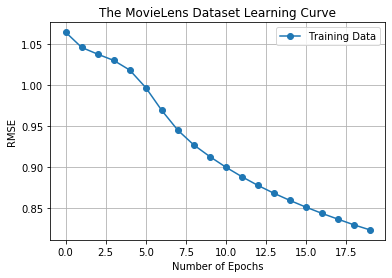

In [135]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5

### (a)

In [0]:
user_euc_recsys = SimBasedRecSys("user","euclidean")
user_sth_recsys = SimBasedRecSys("user","somethingelse")

In [0]:
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       user_euc_recsys,
                       user_sth_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys, 
                       pmf]

In [0]:
cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')
cv_rmse = CrossValidation('RMSE')

In [70]:
Q5_P = cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2042.34it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2050.94it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1997.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2089.02it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2086.16it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2059.23it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2085.05it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2084.74it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2107.76it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2126.44it/s]


Processing algorithm user-euclidean


20000it [00:09, 2095.51it/s]
20000it [00:09, 2121.74it/s]
20000it [00:09, 2111.87it/s]
20000it [00:09, 2111.04it/s]
20000it [00:09, 2077.52it/s]


Processing algorithm user-somethingelse


20000it [00:09, 2118.67it/s]
20000it [00:09, 2114.70it/s]
20000it [00:09, 2094.32it/s]
20000it [00:09, 2120.33it/s]
20000it [00:09, 2089.46it/s]


Processing algorithm user-cosine


20000it [00:09, 2120.32it/s]
20000it [00:09, 2113.08it/s]
20000it [00:09, 2060.29it/s]
20000it [00:09, 2131.79it/s]
20000it [00:09, 2070.91it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2102.58it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2084.45it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2096.07it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2129.32it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2085.34it/s]


Processing algorithm PMF


20000it [00:17, 1094.67it/s]
20000it [00:17, 1152.24it/s]
20000it [00:17, 1166.24it/s]
20000it [00:17, 1147.76it/s]
20000it [00:17, 1134.42it/s]


In [71]:
Q5_R = cv_ratk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2080.98it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2131.93it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2117.75it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2095.06it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2086.62it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2080.04it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2128.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2108.58it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2085.95it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2098.90it/s]


Processing algorithm user-euclidean


20000it [00:09, 2061.91it/s]
20000it [00:09, 2081.43it/s]
20000it [00:09, 2014.09it/s]
20000it [00:09, 2084.18it/s]
20000it [00:09, 2078.83it/s]


Processing algorithm user-somethingelse


20000it [00:09, 2072.70it/s]
20000it [00:09, 2083.31it/s]
20000it [00:09, 2103.31it/s]
20000it [00:09, 2086.01it/s]
20000it [00:09, 2080.41it/s]


Processing algorithm user-cosine


20000it [00:09, 2108.01it/s]
20000it [00:09, 2078.26it/s]
20000it [00:09, 2092.05it/s]
20000it [00:09, 2126.91it/s]
20000it [00:09, 2123.32it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2096.48it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2119.10it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2081.88it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2084.95it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2076.71it/s]


Processing algorithm PMF


20000it [00:17, 1132.76it/s]
20000it [00:17, 1149.86it/s]
20000it [00:17, 1137.96it/s]
20000it [00:17, 1129.31it/s]
20000it [00:17, 1140.74it/s]


In [72]:
Q5_RMSE = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2100.42it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2074.58it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2070.93it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2140.50it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2086.03it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2029.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2166.87it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2172.62it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2072.26it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2117.00it/s]


Processing algorithm user-euclidean


20000it [00:09, 2055.95it/s]
20000it [00:10, 1936.66it/s]
20000it [00:09, 2015.63it/s]
20000it [00:09, 2035.23it/s]
20000it [00:09, 2030.71it/s]


Processing algorithm user-somethingelse


20000it [00:09, 2010.11it/s]
20000it [00:09, 2022.29it/s]
20000it [00:10, 1992.27it/s]
20000it [00:09, 2013.67it/s]
20000it [00:09, 2010.79it/s]


Processing algorithm user-cosine


20000it [00:10, 1996.46it/s]
20000it [00:10, 1985.83it/s]
20000it [00:09, 2012.96it/s]
20000it [00:10, 1968.48it/s]
20000it [00:09, 2035.03it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:10, 1984.63it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:10, 1964.75it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:10, 1957.77it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:10, 1989.01it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2023.57it/s]


Processing algorithm PMF


20000it [00:19, 1045.90it/s]
20000it [00:19, 1049.14it/s]
20000it [00:19, 1042.85it/s]
20000it [00:19, 1043.67it/s]
20000it [00:18, 1054.17it/s]


In [73]:
Q5_P

{'PMF': [[0.36861081654294897,
   0.5126193001060457,
   0.6258748674443285,
   0.6475079533404036,
   0.6369034994697776],
  0.5583032873807009,
  0.4103788826732692,
  0.7062276920881325],
 'item-cosine': [[0.34316012725344736,
   0.483563096500532,
   0.6021208907741271,
   0.6248144220572649,
   0.6074231177094392],
  0.5322163308589621,
  0.3837005215009889,
  0.6807321402169354],
 'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'user-euclidean': [[0.36839872746553626,
   0.5041357370095453,
   0.6176033934252402,
   0.6430540827147414,
   0.6294803817603402],
  0.5525344644750807,
  0.40747105637862135,
  0.69759787257154],
 'user-someth

In [74]:
df_p = pd.DataFrame(Q5_P,index = ['score','Mean', 'CI_lower_bound',"CI_upper_bound"])[1:].T
df_p

,Mean,CI_lower_bound,CI_upper_bound
popularity,0.550583,0.405441,0.695725
useraverage,0.473637,0.341999,0.605275
user-euclidean,0.552534,0.407471,0.697598
user-somethingelse,0.552195,0.406721,0.69767
user-cosine,0.555843,0.409598,0.702088
item-cosine,0.532216,0.383701,0.680732
PMF,0.558303,0.410379,0.706228


In [75]:
df_r = pd.DataFrame(Q5_R,index = ['score','Mean', 'CI_lower_bound',"CI_upper_bound"])[1:].T
df_r

,Mean,CI_lower_bound,CI_upper_bound
popularity,0.484076,0.367137,0.601014
useraverage,0.441323,0.32931,0.553336
user-euclidean,0.483823,0.365321,0.602325
user-somethingelse,0.483841,0.365807,0.601876
user-cosine,0.486269,0.369447,0.60309
item-cosine,0.474971,0.353573,0.596369
PMF,0.4854,0.367702,0.603099


In [76]:
df_rmse = pd.DataFrame(Q5_RMSE,index = ['score','Mean', 'CI_lower_bound',"CI_upper_bound"])[1:].T
df_rmse

,Mean,CI_lower_bound,CI_upper_bound
popularity,3.15909,3.13929,3.17889
useraverage,1.04372,1.02893,1.0585
user-euclidean,1.02249,1.01371,1.03127
user-somethingelse,1.0224,1.01353,1.03126
user-cosine,1.01735,1.00901,1.0257
item-cosine,1.02008,1.00682,1.03334
PMF,0.936816,0.92463,0.949001


### (b)

According to the RMSE table, the Popularity method performs very bad in terms of rmse. So Popularity baseline recommonder cannot be evaluated by RMSE, popularity returns scale between 0-1 if a movie is liked or not (# of user liked / # of user rated), not a rating. Rating scales from 1-5. No meaning for finding root mean square error for popularity.

### (c)

P@K: user-cosine 

R@K: user-cosine

RMSE: PMF - lowest RMSE.


user-cosine is the best method for P@K and R@K since it considers the similarity between users. Popularity and user-average cannot represent a personalized result. And distances methods do not normalize the length of the vectors.

The PMF is the best in the RMSE based since the objective of PMF is to reduce rmse.

### (d)

good performance on RMSE cannot 100% imply good performance in ranking matrics. Apart from popularity, alough other 3 recommenders stats a negatively correlation between RMSE and Ranking metrics (lower rmse -> better ranking metric), some other examples may violate the seemingly correct correlation.


*   eg: RMSE for [4,9, 5.0] and [0.9, 1.0] are same but cannot reflect same ranking performance

*   below table indicates two sets of data having same SUM Error Square and Mean SE
---
| X Value       | Error (Err) = (µ-X)| Error Squared (Err²) |
| ------------- |:-------------:| -----:|
| 0.9(4.9)      | -0.05 | 0.0025 |
| 1.0(5.0)     | 0.05   |   0.0025 |


Since we are caring about ranking instead of prediction, p@K and R@K is better since RMSE "averaging" all the recommendations while P@K and R@K consider only top k recommendations. So good RMSE does not imply good ranking. If RMSE = 0(perfect rmse) can lead to perfect prediction and perfect ranking.


## Q6

### (a)

In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

In [0]:
pd.set_option('display.max_rows',None)

In [0]:
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
ii_sim = SimBasedRecSys.cosine(train_matrix.T)

In [80]:
moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
ii_sim = SimBasedRecSys.cosine(train_matrix.T)
def get5Items(ii_sim,movie_id):
  i = ii_sim[movie_id-1]
  top5 = np.argsort(i)[::-1][1:6]
  df = moviesDF.iloc[np.argsort(i)[::-1][1:6]]
  return df

In [82]:
get5Items(ii_sim,455)

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
23,24,Rumble in the Bronx (1995),23-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Hong%20Faan%2...,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
127,128,Supercop (1992),26-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Police%20Stor...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
221,222,Star Trek: First Contact (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
545,546,Broken Arrow (1996),09-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Broken%20Arro...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [83]:
get5Items(ii_sim,6)

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
1369,1370,I Can't Sleep (J'ai pas sommeil) (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?J'ai%20pas%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1128,1129,Chungking Express (1994),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Chongqing%20S...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
1195,1196,"Savage Nights (Nuits fauves, Les) (1992)",01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Nuits%20fauve...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
220,221,Breaking the Waves (1996),15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Breaking%20th...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1201,1202,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)",19-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Bewegte%20Man...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
get5Items(ii_sim,1425)

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
1508,1509,Getting Even with Dad (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Getting%20Eve...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1602,1603,Angela (1995),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Angela%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1445,1446,"Bye Bye, Love (1995)",01-Jan-1995,NaN,"http://us.imdb.com/M/title-exact?Bye%20Bye,%20...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
800,801,"Air Up There, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Air%20Up%20Th...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1434,1435,"Steal Big, Steal Little (1995)",01-Jan-1995,NaN,"http://us.imdb.com/M/title-exact?Steal%20Big,%...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### (b)

Yes since similar users tend to watch similar movies(e.g. similar in terms of gerne), Jackie Chan's First Strike - Top 5 similar movies are all action movies: Broken Arrow, Star Trek,Supercop,Rumble in the Bronx

## Q7

### (a)

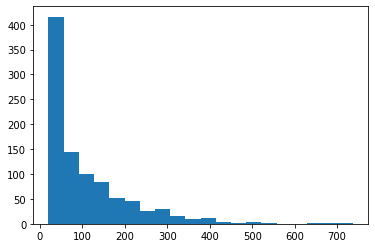

In [85]:
temp_matrix = np.zeros(train_matrix.shape)
temp_matrix[train_matrix.nonzero()] = 1
user_rated_count= np.sum(temp_matrix, axis =1)
plt.hist(user_rated_count, bins = 20)
plt.show()

In [86]:
threshold = median(user_rated_count)
threshold

65.0

In [0]:
rated_count_above_threshold_matrix = train_matrix[user_rated_count>threshold]
rated_count_below_threshold_matrix = train_matrix[user_rated_count<=threshold]

In [0]:
def predict_new(train_matrix, base):
    if base == 'user':
        ########### your code goes here ###########
        #generate a same size matrix as train_matrix with 0s
        temp_matrix = np.zeros(train_matrix.shape)

        # add 1s if user has already rated a movie (no need to normalize later)
        temp_matrix[train_matrix.nonzero()] = 1

        # calculate user user similarity for cosine
        uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')

        #calculater normalizer (denominator) - sum of all other user's similarity to target user's target movie 
        normalizer = np.matmul(uu_similarity, temp_matrix)

        # need to add a small number for normalizer to avoid dividing by 0
        normalizer[normalizer==0] =1e-5

        # matrix multiplication - user-similarity * their rating, and normalize
        predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer

        # calculate user average for later use(in case no one rated a movie, use user average)
        useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)

        # sum up predicted ratings for each item (identify items with 0 ratings)
        columns = np.sum(predictionMatrix, axis=0)

        # for those with 0 ratings, assign user's average rating
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

        return predictionMatrix

        ###########         end         ###########

    elif base == 'item':
        ########### your code goes here ###########
        # turn 943 * 1682 into 1682 * 943
        train_matrix = train_matrix.T

        #generate a same size matrix as train_matrix with 0s
        temp_matrix = np.zeros(train_matrix.shape)

        # add 1s if user has already rated a movie (no need to normalize later)
        temp_matrix[train_matrix.nonzero()] = 1

        # 1682 * 1682
        ii_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')

        normalizer = np.matmul(ii_similarity, temp_matrix)
        normalizer[normalizer==0] = 1e-5
        predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer

        itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
        columns = np.sum(predictionMatrix, axis=0)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)

        return predictionMatrix.T

        ###########         end         ###########
    else:
        print('No other option available')

In [0]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data

In [0]:
def threshold_rmse(train_df, test_df):
    
    # Building User-to-Item Rating Matrix for train and test data
    user_item_matrix_train = dataPreprocessor(train_df,num_users,num_items)
    user_item_matrix_test = dataPreprocessor(test_df,num_users,num_items)
    
    # split main train user-item rating matrix into two sub-matrix based on user_rated_count(threshold)
    rated_above_matrix_train = user_item_matrix_train[user_rated_count>threshold] 
    rated_below_matrix_train = user_item_matrix_train[user_rated_count<=threshold]
    
    # split main test user-item rating matrix into two sub-matrix based on user_rated_count(threshold)
    rated_above_matrix_test = user_item_matrix_test[user_rated_count>threshold]
    rated_below_matrix_test = user_item_matrix_test[user_rated_count<=threshold]
    
    # for user-user cosine similarity prediction , predict ratings for both above and below dataset
    user_cosine_above = predict_new(rated_above_matrix_train, "user")
    user_cosine_below = predict_new(rated_below_matrix_train, "user")
    
    # for item-item cosine similarity prediction , predict ratings for both above and below dataset
    item_cosine_above = predict_new(rated_above_matrix_train, "item")
    item_cosine_below = predict_new(rated_below_matrix_train, "item")
    
    #calculate rmse between above results and target test matrics
    rmse_user_above = rmse(user_cosine_above, rated_above_matrix_test)
    rmse_user_below = rmse(user_cosine_below, rated_below_matrix_test)
    
    rmse_item_above = rmse(item_cosine_above, rated_above_matrix_test)
    rmse_item_below = rmse(item_cosine_below, rated_below_matrix_test)
    
    print("rmse_user_above: " + str(rmse_user_above) + "\n"
          "rmse_user_below: " + str(rmse_user_below) + "\n"
          "rmse_item_above: " + str(rmse_item_above) + "\n"
          "rmse_item_below: " + str(rmse_item_below))
    
    return rmse_user_above,rmse_user_below,rmse_item_above,rmse_item_below

In [92]:
(predict_new(rated_count_above_threshold_matrix,"user").shape,predict_new(rated_count_below_threshold_matrix,"user").shape)

((466, 1682), (477, 1682))

In [93]:
len(rating_df.userID.unique()) == predict_new(rated_count_above_threshold_matrix,"user").shape[0] + predict_new(rated_count_below_threshold_matrix,"user").shape[0]

True

In [0]:
# get train data_df
train_df_1 = getData(MOVIELENS_DIR, 'u1.base')
train_df_2 = getData(MOVIELENS_DIR, 'u2.base')
train_df_3 = getData(MOVIELENS_DIR, 'u3.base')
train_df_4 = getData(MOVIELENS_DIR, 'u4.base')
train_df_5 = getData(MOVIELENS_DIR, 'u5.base')

# test data df
test_df_1 = getData(MOVIELENS_DIR, 'u1.test')
test_df_2 = getData(MOVIELENS_DIR, 'u2.test')
test_df_3 = getData(MOVIELENS_DIR, 'u3.test')
test_df_4 = getData(MOVIELENS_DIR, 'u4.test')
test_df_5 = getData(MOVIELENS_DIR, 'u5.test')

# get lists of train and test sets
trainset = [train_df_1,train_df_2,train_df_3,train_df_4,train_df_5]
testset = [test_df_1,test_df_2,test_df_3,test_df_4,test_df_5]

In [0]:
test = np.array([5])

In [96]:
np.append(test,1)

array([5, 1])

In [0]:
rmse_user_above=np.array([])
rmse_user_below=np.array([])
rmse_item_above=np.array([])
rmse_item_below=np.array([])

In [98]:
for i in range(5):
  print("\nFor dataset "+str(i+1))
  rmse_user_above_temp, rmse_user_below_temp, rmse_item_above_temp,  rmse_item_below_temp=threshold_rmse(trainset[i],testset[i])
  rmse_user_above = np.append(rmse_user_above,rmse_user_above_temp)
  rmse_user_below = np.append(rmse_user_below,rmse_user_below_temp)
  rmse_item_above = np.append(rmse_item_above,rmse_item_above_temp)
  rmse_item_below = np.append(rmse_item_below,rmse_item_below_temp)

print("\nAverage performance through 5-fold validation: \nmean_rmse_user_above: " + str(rmse_user_above.mean()) + "\n"
          "mean_rmse_user_below: " + str(rmse_user_below.mean()) + "\n"
          "mean_rmse_item_above: " + str(rmse_item_above.mean()) + "\n"
          "mean_rmse_item_below: " + str(rmse_item_below.mean()))


For dataset 1
rmse_user_above: 1.0217224238522409
rmse_user_below: 1.0925082986968262
rmse_item_above: 1.0420718763092183
rmse_item_below: 1.1591606785239992

For dataset 2
rmse_user_above: 1.0120730496853942
rmse_user_below: 1.1125380537421266
rmse_item_above: 1.019209168113586
rmse_item_below: 1.1457109707029793

For dataset 3
rmse_user_above: 1.0077844097606357
rmse_user_below: 1.0896662791465428
rmse_item_above: 1.0071054788694778
rmse_item_below: 1.1384712875365235

For dataset 4
rmse_user_above: 1.0014319590057332
rmse_user_below: 1.0980748043537147
rmse_item_above: 1.009676620888213
rmse_item_below: 1.1323950504334444

For dataset 5
rmse_user_above: 1.010699717208189
rmse_user_below: 1.1042194022963487
rmse_item_above: 1.0184146217690633
rmse_item_below: 1.1092489872604028

Average performance through 5-fold validation: 
mean_rmse_user_above: 1.0107423119024386
mean_rmse_user_below: 1.0994013676471117
mean_rmse_item_above: 1.0192955531899117
mean_rmse_item_below: 1.136997394891



*   The CF model with user-cosine out performed item cosine for above and below threshold respectively.
*   user-rated more than threshold (65) have a better rmse value compare to those who rated fewer than threshold

*   people who rated more movies once got splited into separated train matrix, user-item matrix will be denser -> result in a more features train data.(note the # above vs # below is 466vs477)

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [103]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [109]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [115]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [117]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)